# Convolutional neural networks
This notebook uses the `hybridmodels-modelbuild` virtual environment.

In [564]:
from os.path import join
import glob
from itertools import compress

import numpy as np
import pandas as pd
import tensorflow as tf
import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

# functions to get dimensions to create node feature matrices for grid
def get_rows_and_cols(df, gridsize=500):
    """
    Parameters:
    -----------
    gridsize : float
        length of one side of a square gridcell in grid.
    """
    from shapely.geometry import box
    df_pm = df.to_crs("EPSG:3857")
    bbounds = df_pm.total_bounds
    width = bbounds[2] - bbounds[0]
    height = bbounds[3] - bbounds[1]
    nrows = int(np.round(height / gridsize, 0))
    ncols = int(np.round(width  / gridsize, 0))
    return nrows, ncols

def reshape_df(df, nrows, ncols, features):
    df = df.drop("geometry", axis=1)
    feature_mat = np.empty(shape=(nrows, ncols, len(features)), dtype="float")
    for i, feature in enumerate(features):
        feature_arr = df[feature].values.reshape(nrows, ncols, order="F")
        feature_mat[:, :, i] = feature_arr
    return feature_mat

## Load and parse data

In [565]:
# load the data
wd = join("..", "data", "indata_new")
features = ['gebco', 'fabdem', 'jrc_permwa', 'precip', 'soilcarbon', 'mangrove', 'ndvi', 'wind_avg']
columns = features + ['storm', 'region', 'subregion', "geometry", "floodfrac"]

# separate files based on staggering level
files = [filename for filename in glob.glob(join(wd, "feature_stats", "*.shp"))]
orig_mask = [True if filename.split('.')[-2][-2:] == '_0' else False for filename in files]
plus_mask = [True if filename.split('.')[-2][-4:] == '_250' else False for filename in files]
minus_mask = [True if filename.split('.')[-2][-4:] == '-250' else False for filename in files]
orig = list(compress(files, orig_mask))
plus = list(compress(files, plus_mask))
minus = list(compress(files, minus_mask))

# format event columns
def format_gdf(gdf, filelist):
    l = [gpd.read_file(filename) for filename in filelist]
    gdf = pd.concat(l, axis=0)
    gdf = gdf[columns]
    gdf["event"] = gdf["storm"] + "_" + gdf["region"] + "_" + gdf["subregion"].astype(str)
    gdf = gdf.drop(["storm", "region", "subregion"], axis=1).reset_index(drop=True)
    return gdf

gdf = format_gdf(gdf, orig)
gdf_plus = format_gdf(gdf, plus)
gdf_minus = format_gdf(gdf, minus)


columns.remove("storm")
columns.remove("region")
columns.remove("subregion")

### EDA

<AxesSubplot:>

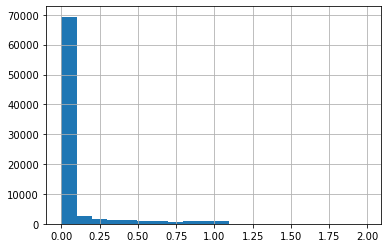

In [566]:
# Flood fraction for non-staggered data
gdf['floodfrac'].hist(bins=20)

In [567]:
print(f"skew: {gdf['floodfrac'].skew()}")
print(f"kurtosis: {gdf['floodfrac'].kurtosis()}")
gdf['floodfrac'].describe()

skew: 3.2991172550079226
kurtosis: 11.448797234361642


count    81920.000000
mean         0.082418
std          0.227613
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.988365
Name: floodfrac, dtype: float64

### Format training set

Text(0.5, 1.0, 'Flood fraction')

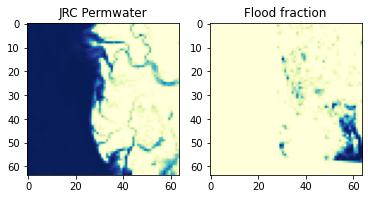

In [568]:
# preview training set
events = [*gdf['event'].unique()]

event = 'batsirai_tsiribihina_0'
temp = gdf[gdf.event==str(event)]
nrows, ncols = get_rows_and_cols(temp, gridsize=500)
X = reshape_df(temp, nrows, ncols, features)
y = reshape_df(temp, nrows, ncols, ["floodfrac"])

# clip to size
X = X[:64, :64, :]
y = y[:64, :64, 0]

a, b, c = X.shape
Xmat = np.zeros((64, 64, c), dtype=float)
ymat = np.zeros((64, 64), dtype=float)
Xmat[:a, :b, :] = X
ymat[:a, :b] = y

fig, ax = plt.subplots(1, 2)
ax[0].imshow(Xmat[:, :, 2], cmap="YlGnBu")
ax[0].set_title("JRC Permwater")
ax[1].imshow(ymat, cmap="YlGnBu")
ax[1].set_title("Flood fraction")

In [569]:
Xmats = []
ymats = []

def get_matrices(gdf, gridsize, features):
    """Helper function for reshaping."""
    nrows, ncols = get_rows_and_cols(gdf, gridsize=gridsize)
    X = reshape_df(gdf, nrows, ncols, features)
    y = reshape_df(gdf, nrows, ncols, ["floodfrac"])
    
    # clip to 64x64 images
    X = X[:64, :64, :]
    y = y[:64, :64, 0]
    
    a, b, c = X.shape
    Xmat = np.zeros((64, 64, c), dtype=float)
    ymat = np.zeros((64, 64), dtype=float)
    Xmat[:a, :b, :] = X
    ymat[:a, :b] = y
    return Xmat, ymat
    
# now calculate X and y matrices
for event in [*gdf['event'].unique()]:
    temp = gdf[gdf.event==str(event)]
    if len(temp) > 0:
        Xmat, ymat = get_matrices(temp, 500, features)
        Xmats.append(Xmat)
        ymats.append(ymat)
    
for event in [*gdf_plus['event'].unique()]:
    temp = gdf_plus[gdf_plus.event==str(event)]
    if len(temp) > 0:
        Xmat, ymat = get_matrices(temp, 500, features)
        Xmats.append(Xmat)
        ymats.append(ymat)
        
for event in [*gdf_minus['event'].unique()]:
    temp = gdf_minus[gdf_minus.event==str(event)]
    if len(temp) > 0:
        Xmat, ymat = get_matrices(temp, 500, features)
        Xmats.append(Xmat)
        ymats.append(ymat)

In [570]:
# create TensorFlow datasets with batch size 1 (since small dataset)
n = len(Xmats)
ntrain = int(0.8 * n)
ntest = int(0.1 * n)

# NOTE: shuffling seems to confuse (X, y) pairs and there is no need to shuffle anyway
data = tf.data.Dataset.from_tensor_slices((Xmats, ymats)).batch(1)
train = data.take(ntrain)
test = data.skip(ntrain)
valid = test.skip(ntest)
test = test.take(ntest)

X_train = [element[0].numpy()[0, :, :, :] for element in train]
y_train = [element[1].numpy()[0, :, :] for element in train]
X_valid = [element[0].numpy()[0, :, :, :] for element in valid]
y_valid = [element[1].numpy()[0, :, :] for element in valid]
X_test = [element[0].numpy()[0, :, :, :] for element in test]
y_test = [element[1].numpy()[0, :, :] for element in test]

print("Training size:", len(X_train))
print("Validation size:", len(X_valid))
print("Test size:", len(X_test))

Training size: 28
Validation size: 5
Test size: 3


### View training set

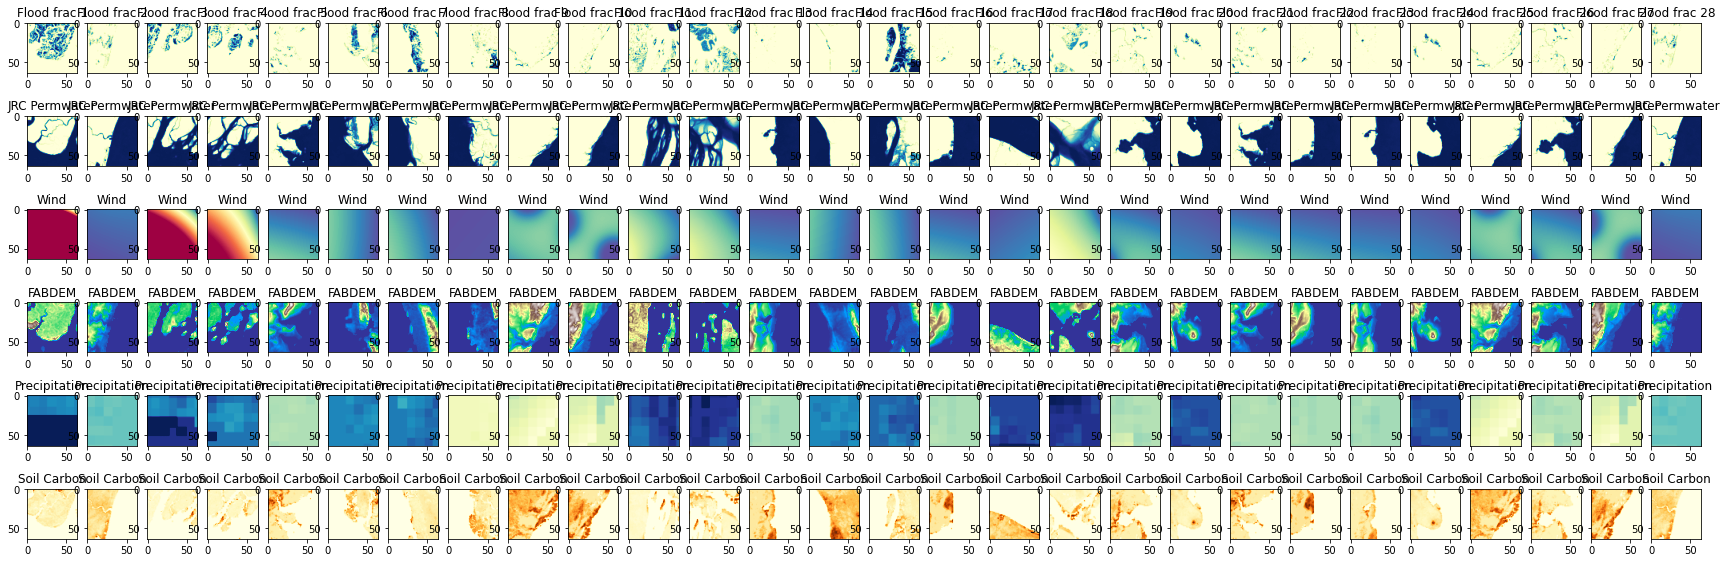

In [572]:
fig, ax = plt.subplots(6, len(y_train), figsize=(30, 10))

for i, im in enumerate(y_train):
    pos = ax[0, i].imshow(im, cmap="YlGnBu")
    ax[0, i].set_title(f"Flood frac {i+1}")
    
for i, im in enumerate(X_train):
    pos = ax[1, i].imshow(im[:, :, 2], cmap="YlGnBu")
    ax[1, i].set_title("JRC Permwater")

for i, im in enumerate(X_train):
    pos = ax[3, i].imshow(im[:, :, 0], cmap="terrain", vmin=0)
    ax[3, i].set_title("FABDEM")

for i, im in enumerate(X_train):
    pos = ax[2, i].imshow(im[:, :, 7], cmap="Spectral_r", vmax=10)
    ax[2, i].set_title("Wind")
    
for i, im in enumerate(X_train):
    pos = ax[4, i].imshow(im[:, :, 3], cmap="YlGnBu", vmin=0, vmax=40)
    ax[4, i].set_title("Precipitation")
    
for i, im in enumerate(X_train):
    pos = ax[5, i].imshow(im[:, :, 4], cmap="YlOrBr", vmin=0)
    ax[5, i].set_title("Soil Carbon")

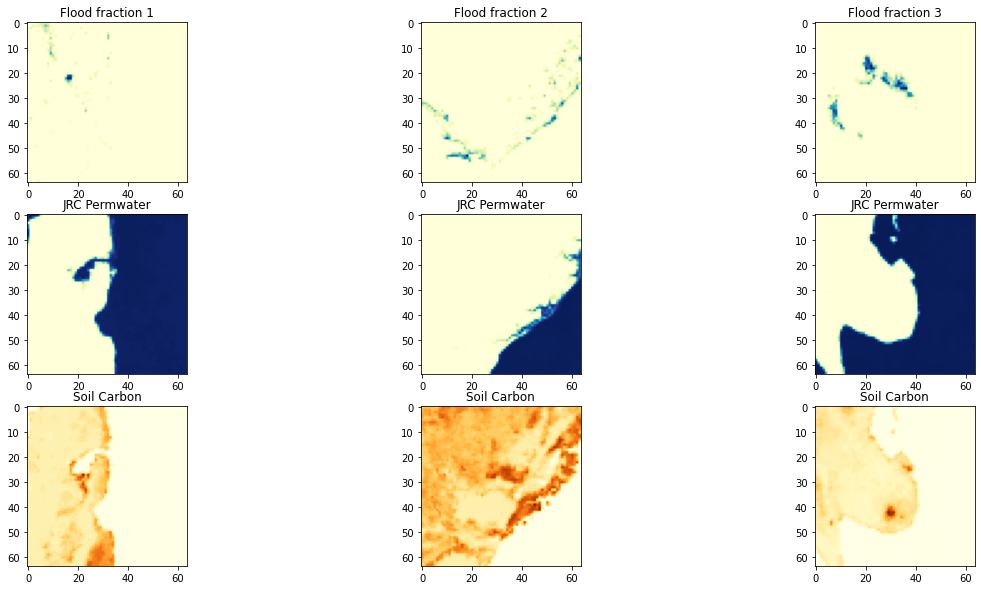

In [573]:
fig, ax = plt.subplots(3, len(y_test), figsize=(20, 10))
for i, im in enumerate(y_test):
    pos = ax[0, i].imshow(im, cmap="YlGnBu")
    ax[0, i].set_title(f"Flood fraction {i+1}")
    
for i, im in enumerate(X_test):
    pos = ax[1, i].imshow(im[:, :, 2], cmap="YlGnBu")
    ax[1, i].set_title("JRC Permwater")
    
for i, im in enumerate(X_test):
    pos = ax[2, i].imshow(im[:, :, 4], cmap="YlOrBr", vmin=0)
    ax[2, i].set_title("Soil Carbon")

Convolutional Neural Networks
[Tutorial here](https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/)
### Model hyperparameters
Since the target variable `floodfrac` is very positively-skewed, with many zeros, any Gaussian-assuming loss function such as RMSE can lead to poor results due to zero-inflation. The Tweedie loss function has been developed to deal with this sort of data and is [often used in predicting insurance claims](https://towardsdatascience.com/tweedie-loss-function-for-right-skewed-data-2c5ca470678f). A custom TensorFlow function is provided [here](https://towardsdatascience.com/tweedie-loss-function-for-right-skewed-data-2c5ca470678f). The loss function has the following form,

$$ \mathcal{L}(p) = -\sum_{i} x_i \frac{\hat x_i^{1-p}}{1-p} + \frac{\hat x^{2-p}}{2-p}$$

where $y$ is the trye value, and $\hat y$ is the predicted value. For the optimiser either, stochastic gradient descent with a small (1e-6) learning rate, or else Adam with an adaptive learning rate will be used. Epochs range between 20 and 200 and will need to be explored.
#### Possible future extensions
1. [ ] partialconv padding
2. [ ] dilation to layers

In [574]:
from keras import Sequential
from keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, concatenate
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model

def Tweedie(p):
    def tweedie_loglikelihood(y, y_hat):
        loss = - y * tf.pow(y_hat, 1 - p) / (1 - p) + \
               tf.pow(y_hat, 2 - p) / (2 - p)
        return tf.reduce_mean(loss)
    return tweedie_loglikelihood

def plot_history(history):
    plt.figure()
    plt.xlabel('epoch')
    plt.ylabel('root mean squared error')
    plt.plot(history.epoch, np.array(history.history['root_mean_squared_error']), 
           label='train')
    plt.plot(history.epoch, np.array(history.history['val_root_mean_squared_error']),
           label = 'valid')
    plt.legend()
    plt.ylim([0, max(history.history['loss'])])
    
def plot_prediction(test_labels, y_pred, title):
    plt.figure()
    plt.title(title)
    plt.scatter(test_labels, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    _ = plt.plot([-100, 100],[-100,100])

    plt.figure()
    error = y_pred - test_labels
    plt.hist(error, bins = 50)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")

#### SCNN Matéo-Garcia (2021)

In [575]:
def build_scnn(shape=(128, 128, 3)):
    inputs = Input(shape=shape)
    normalized = BatchNormalization(axis=3)(inputs)
    x = Conv2D(64, 3, padding="same", activation="relu")(normalized)
    x = Conv2D(128, 3, padding="same", activation="relu")(x)
    x = Conv2D(128, 3, padding="same", activation="relu")(x)
    
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(x)
    scnn = Model(inputs, outputs, name="SCNN")
    return scnn

In [576]:
scnn = build_scnn(shape=(64, 64, len(gdf[features].columns)))
scnn.summary()

Model: "SCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 64, 64, 8)]       0         
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 8)        32        
 chNormalization)                                                
                                                                 
 conv2d_507 (Conv2D)         (None, 64, 64, 64)        4672      
                                                                 
 conv2d_508 (Conv2D)         (None, 64, 64, 128)       73856     
                                                                 
 conv2d_509 (Conv2D)         (None, 64, 64, 128)       147584    
                                                                 
 conv2d_510 (Conv2D)         (None, 64, 64, 1)         129       
                                                              

In [577]:
scnn.compile(optimizer=SGD(learning_rate=1e-6), loss=Tweedie(1.5), metrics="RootMeanSquaredError")
history = scnn.fit(train, epochs=40, validation_data=valid, callbacks=EarlyStopping(patience=3))

!say done

Epoch 1/40
28/28 [==============================] - 2s 43ms/step - loss: 1.6496 - root_mean_squared_error: 0.5225 - val_loss: 1.6634 - val_root_mean_squared_error: 0.6358
Epoch 2/40
28/28 [==============================] - 1s 39ms/step - loss: 1.6495 - root_mean_squared_error: 0.5224 - val_loss: 1.6404 - val_root_mean_squared_error: 0.6155
Epoch 3/40
28/28 [==============================] - 1s 39ms/step - loss: 1.6495 - root_mean_squared_error: 0.5224 - val_loss: 1.6236 - val_root_mean_squared_error: 0.6017
Epoch 4/40
28/28 [==============================] - 1s 38ms/step - loss: 1.6494 - root_mean_squared_error: 0.5223 - val_loss: 1.6116 - val_root_mean_squared_error: 0.5926
Epoch 5/40
28/28 [==============================] - 1s 48ms/step - loss: 1.6493 - root_mean_squared_error: 0.5223 - val_loss: 1.6053 - val_root_mean_squared_error: 0.5885
Epoch 6/40
28/28 [==============================] - 1s 48ms/step - loss: 1.6493 - root_mean_squared_error: 0.5223 - val_loss: 1.6073 - val_root_m

Testing set root mean squared error: 0.61


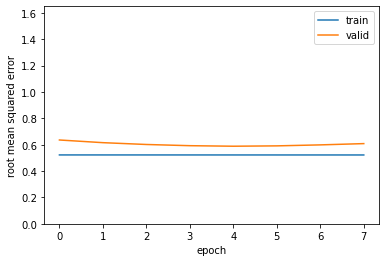

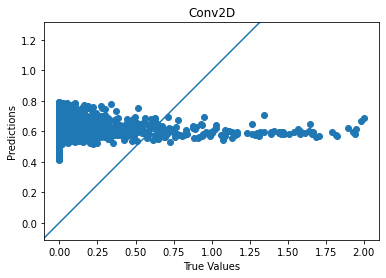

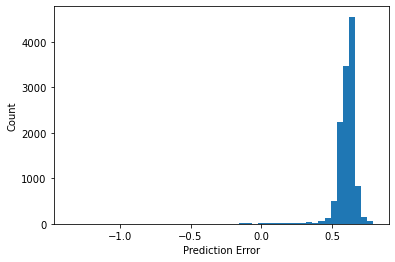

In [578]:
plot_history(history)

[loss, rmse] = scnn.evaluate(test, verbose=0)
print("Testing set root mean squared error: {:4.2f}".format(rmse))

y_pred = scnn.predict(test)
plot_prediction(np.array(y_test).flatten(), y_pred.flatten(), "Conv2D")

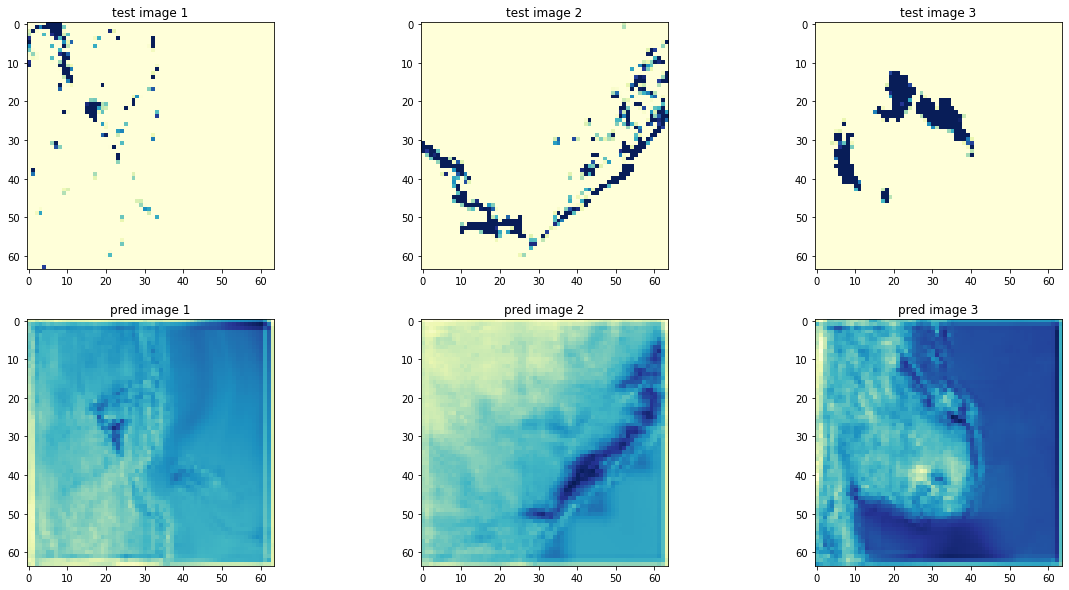

In [579]:
fig, ax = plt.subplots(2, len(y_test), figsize=(20, 10))

for i, im in enumerate(y_test):
    pos = ax[0, i].imshow(im, cmap="YlGnBu", vmin=0, vmax=0.1)
    ax[0, i].set_title(f"test image {i+1}")
    
for i, im in enumerate(y_test):
    pos = ax[0, i].imshow(im, cmap="YlGnBu", vmin=0, vmax=0.1)
    ax[0, i].set_title(f"test image {i+1}")
    
for i, _ in enumerate(y_test):
    ax[1, i].imshow(y_pred[i, :, :, 0], cmap="YlGnBu")
    ax[1, i].set_title(f"pred image {i+1}")

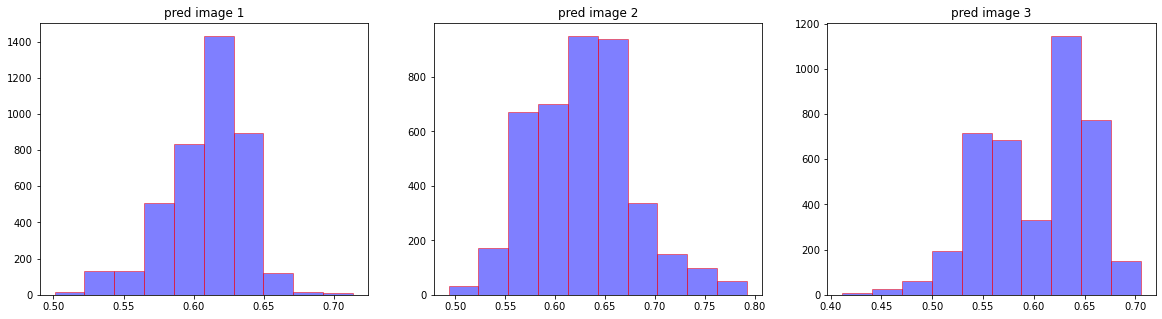

In [580]:
fig, ax = plt.subplots(1, len(y_test), figsize=(20, 5))

for i, _ in enumerate(y_test):
    ax[i].hist(y_pred[i, :, :, 0].flatten(), alpha=0.5, edgecolor="red", color="blue")
    ax[i].set_title(f"pred image {i+1}")

### U-Net

In [581]:
# define the U-Net architecture (from Tutorial)
def double_conv_block(x, depth):
    x = Conv2D(depth, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(x)
    x = Conv2D(depth, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(x)
    return x

def downsample_block(x, depth):
    f = double_conv_block(x, depth)
    p = MaxPooling2D(2)(f)
    p = Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, depth):
    x = Conv2DTranspose(depth, 3, 2, padding="same")(x)
    x = concatenate([x, conv_features])
    x = Dropout(0.3)(x)
    x = double_conv_block(x, depth)
    return x

# compile model using the functional API
def build_unet(shape=(128, 128, 3)):
    inputs = Input(shape=shape)
    normalized = BatchNormalization(axis=3)(inputs)
    
    # encoder
    f1, p1 = downsample_block(normalized, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    
    # bottleneck
    bottleneck = double_conv_block(p4, 1024)
    
    # decoder
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    
    # outputs
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(u9)
    unet = Model(inputs, outputs, name="U-Net")
    return unet

In [582]:
unet = build_unet(shape=(64, 64, len(gdf[features].columns)))
unet.compile(optimizer=SGD(learning_rate=1e-6), loss=Tweedie(1.5), metrics="RootMeanSquaredError")
history = unet.fit(train, epochs=40, validation_data=valid, callbacks=EarlyStopping(patience=3))

!say done

Epoch 1/40
28/28 [==============================] - 8s 230ms/step - loss: 1.5659 - root_mean_squared_error: 0.5160 - val_loss: 1.7353 - val_root_mean_squared_error: 0.7385
Epoch 2/40
28/28 [==============================] - 6s 210ms/step - loss: 1.5657 - root_mean_squared_error: 0.5153 - val_loss: 1.6946 - val_root_mean_squared_error: 0.6961
Epoch 3/40
28/28 [==============================] - 6s 231ms/step - loss: 1.5649 - root_mean_squared_error: 0.5148 - val_loss: 1.6376 - val_root_mean_squared_error: 0.6457
Epoch 4/40
28/28 [==============================] - 6s 219ms/step - loss: 1.5657 - root_mean_squared_error: 0.5157 - val_loss: 1.5806 - val_root_mean_squared_error: 0.5995
Epoch 5/40
28/28 [==============================] - 6s 216ms/step - loss: 1.5628 - root_mean_squared_error: 0.5136 - val_loss: 1.5438 - val_root_mean_squared_error: 0.5730
Epoch 6/40
28/28 [==============================] - 6s 218ms/step - loss: 1.5632 - root_mean_squared_error: 0.5133 - val_loss: 1.5285 - val_

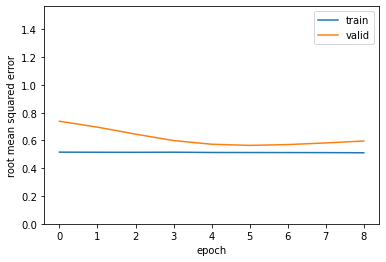

In [583]:
plot_history(history)

Testing set root mean squared error: 0.61


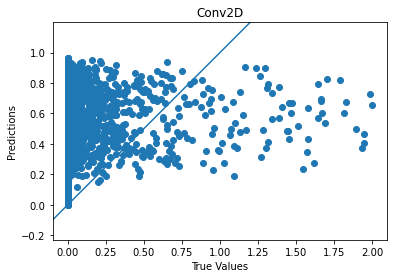

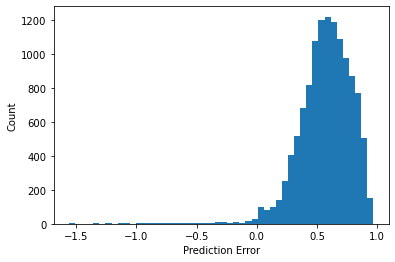

In [584]:
[loss, rmse] = unet.evaluate(test, verbose=0)
print("Testing set root mean squared error: {:4.2f}".format(rmse))

y_pred = unet.predict(test)
plot_prediction(np.array(y_test).flatten(), y_pred.flatten(), "Conv2D")

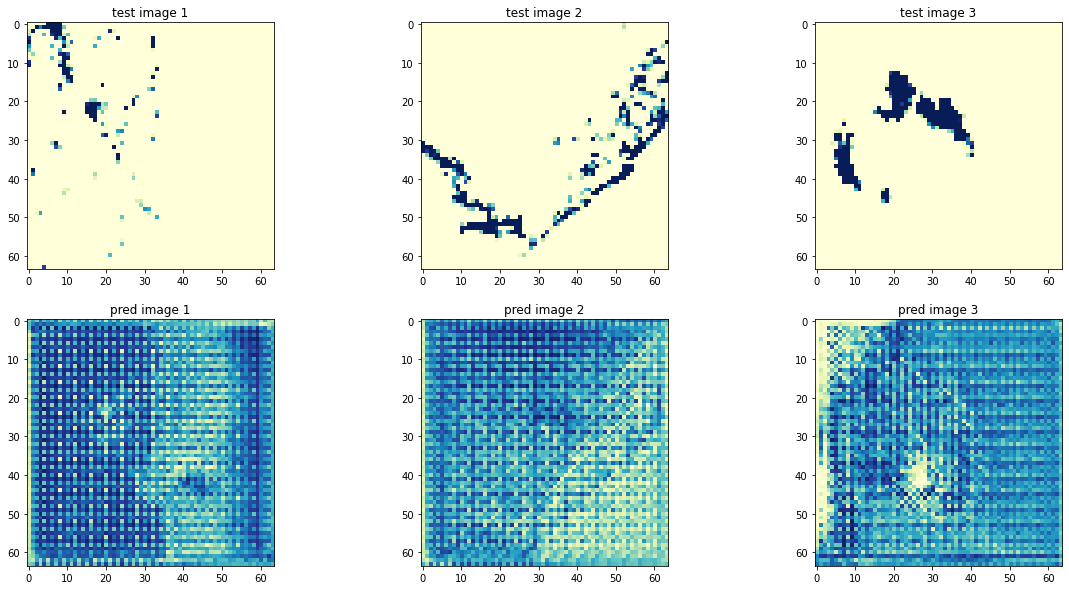

In [585]:
fig, ax = plt.subplots(2, len(y_test), figsize=(20, 10))

for i, im in enumerate(y_test):
    pos = ax[0, i].imshow(im, cmap="YlGnBu", vmin=0, vmax=0.1)
    ax[0, i].set_title(f"test image {i+1}")
    
for i, _ in enumerate(y_test):
    ax[1, i].imshow(y_pred[i, :, :, 0], cmap="YlGnBu")
    ax[1, i].set_title(f"pred image {i+1}")


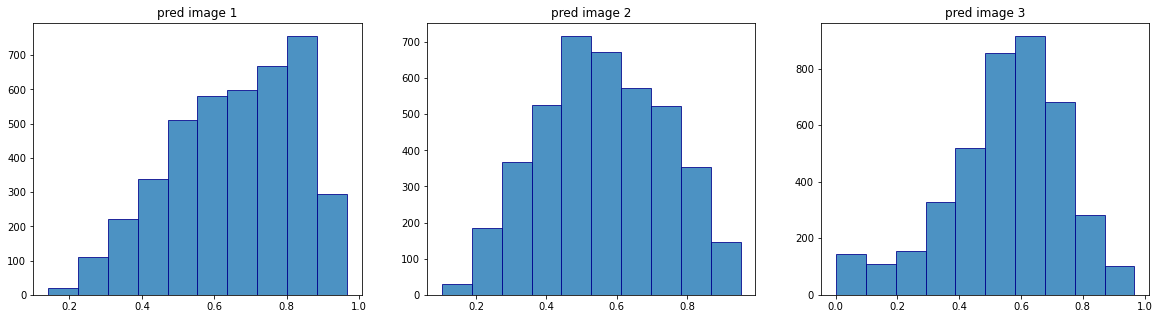

In [586]:
fig, ax = plt.subplots(1, len(y_test), figsize=(20, 5))

for i, _ in enumerate(y_test):
    ax[i].hist(y_pred[i, :, :, 0].flatten(), alpha=0.8, edgecolor="darkblue")
    ax[i].set_title(f"pred image {i+1}")